In [1]:
import html
import io
import os
import time
from datetime import datetime
from pathlib import Path
from typing import Iterable

import requests
import yfinance as yf
from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta import Thread
from openai.types.beta.threads import Run
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile
from PIL import Image

In [2]:
load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

In [3]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

In [4]:
def get_stock_price(symbol: str) -> float:
    stock = yf.Ticker(symbol)
    return stock.history(period="1d")["Close"].iloc[-1]

In [5]:
def send_logic_apps_email(to: str, content: str) -> None:
    json_payload = {"to": to, "content": html.unescape(content)}
    headers = {"Content-Type": "application/json"}
    response = requests.post(email_URI, json=json_payload, headers=headers)
    if response.status_code == 202:
        print("Email sent to: " + json_payload["to"])

In [6]:
tools_list = [
    {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "get_stock_price",
            "description": "Retrieve the latest closing price of a stock using its ticker symbol.",
            "parameters": {
                "type": "object",
                "properties": {"symbol": {"type": "string", "description": "The ticker symbol of the stock"}},
                "required": ["symbol"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "send_email",
            "description": "Sends an email to a recipient(s).",
            "parameters": {
                "type": "object",
                "properties": {
                    "to": {"type": "string", "description": "The email(s) the email should be sent to."},
                    "content": {"type": "string", "description": "The content of the email."},
                },
                "required": ["to", "content"],
            },
        },
    },
]

In [7]:
DATA_FOLDER = "./data/finance/"


def upload_file(client: AzureOpenAI, path: str) -> FileObject:
    with Path(path).open("rb") as f:
        return client.files.create(file=f, purpose="assistants")


arr = os.listdir(DATA_FOLDER)
assistant_files = []
for file in arr:
    filePath = DATA_FOLDER + file
    assistant_files.append(upload_file(client, filePath))

file_ids = [file.id for file in assistant_files]

In [8]:
assistant = client.beta.assistants.create(
    name="Portfolio Management Assistant",
    instructions="You are a personal securities trading assistant. Please be polite, professional, helpful, and friendly. "
    + "Use the provided portfolio CSV file to answer the questions. If question is not related to the portfolio or you cannot answer the question, say, 'contact a representative for more assistance.'"
    + "If the user asks for help or says 'help', provide a list of sample questions that you can answer.",
    tools=tools_list,
    model=api_deployment_name,
    file_ids=file_ids,
)

thread = client.beta.threads.create()

In [9]:
def call_functions(client: AzureOpenAI, thread: Thread, run: Run) -> None:
    print("Function Calling")
    required_actions = run.required_action.submit_tool_outputs.model_dump()
    print(required_actions)
    tool_outputs = []
    import json

    for action in required_actions["tool_calls"]:
        func_name = action["function"]["name"]
        arguments = json.loads(action["function"]["arguments"])

        if func_name == "get_stock_price":
            output = get_stock_price(symbol=arguments["symbol"])
            tool_outputs.append({"tool_call_id": action["id"], "output": output})
        elif func_name == "send_email":
            print("Sending email...")
            # email_to = arguments["to"]
            # email_content = arguments["content"]
            # send_logic_apps_email(email_to, email_content)

            tool_outputs.append({"tool_call_id": action["id"], "output": "Email sent"})
        else:
            raise ValueError(f"Unknown function: {func_name}")

    print("Submitting outputs back to the Assistant...")
    client.beta.threads.runs.submit_tool_outputs(thread_id=thread.id, run_id=run.id, tool_outputs=tool_outputs)

In [10]:
def format_messages(messages: Iterable[MessageFile]) -> None:
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                # Display image
                image.show()

In [11]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="The current date and time is: " + datetime.now().strftime("%x %X") + ".",
    )

    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        if run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            # Handle failed
            break
        if run.status == "expired":
            # Handle expired
            break
        if run.status == "cancelled":
            # Handle cancelled
            break
        if run.status == "requires_action":
            call_functions(client, thread, run)
        else:
            time.sleep(5)

In [12]:
process_message("Based on the provided portfolio, what investments do I own?")

processing...
user:
Based on the provided portfolio, what investments do I own?

assistant:
Based on the provided portfolio file, which is a CSV, you own the following investments:

1. Microsoft Corporation (MSFT) - 300 shares
2. Apple Inc. (AAPL) - 200 shares
3. Amazon.com, Inc. (AMZN) - 50 shares
4. Tesla, Inc. (TSLA) - 100 shares
5. Netflix, Inc. (NFLX) - 80 shares
6. NVIDIA Corporation (NVDA) - 50 shares

The portfolio also includes information about the average cost at which you acquired these shares.



In [13]:
process_message("What is the value of my portfolio?")

processing...
Function Calling
{'tool_calls': [{'id': 'call_DHEF6TMadub1ud2REYDgidUK', 'function': {'arguments': '{"symbol": "MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_wnBWFOsqGpPPgxSi2ponzHq6', 'function': {'arguments': '{"symbol": "AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_fhQuxzCPyJ2d1qVKdNXQ5YKX', 'function': {'arguments': '{"symbol": "AMZN"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_gMsNEBdXalh5T3VtRgfRYqig', 'function': {'arguments': '{"symbol": "TSLA"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_19JA2eBqki3EDGsS4qkF53C6', 'function': {'arguments': '{"symbol": "NFLX"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_F5aqfhiZNiA9TWnKtx8WRbYO', 'function': {'arguments': '{"symbol": "NVDA"}', 'name': 'get_stock_price'}, 'type': 'function'}]}
Submitting outputs back to the Assistant...
user:
What is the value of my portfolio?

assistant:
The current value of your portfol

In [14]:
process_message("What is my best and worst investment?")

processing...
user:
What is my best and worst investment?

assistant:
Your best investment is in Microsoft Corporation (MSFT), with a gain of approximately \$61,749.00. 

Your worst investment is in Tesla, Inc. (TSLA), with a loss of approximately \$70,196.00.



processing...
user:
Chart the realized gain or loss of my investments.

assistant:
It seems that there was an issue with the connection when attempting to generate the chart. Let me try again to create the chart for the realized gain or loss of your investments.

assistant:
It seems that we've encountered an unexpected issue: the plotting library (matplotlib) is not currently defined in this environment, which likely occurred due to the prior connection exception. Let me define it again and recreate the bar chart for the realized gain or loss of your investments.

assistant:
It appears we've encountered another issue: due to the state of the environment being reset, the previous variable definitions (like `symbols` and `gains_losses`) are no longer available. I will need to redefine these variables and then attempt to create the chart once more. Kindly bear with me while I perform these steps.



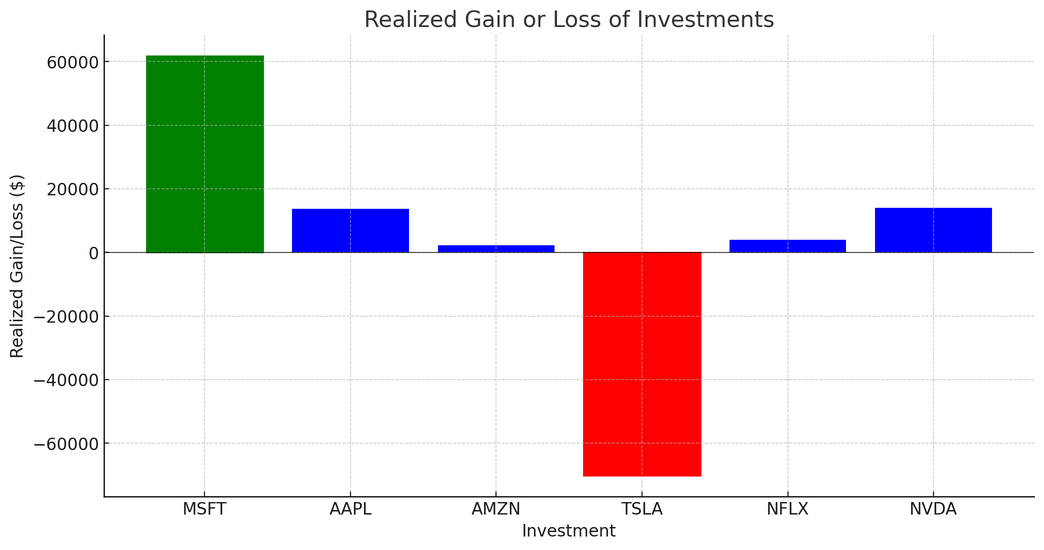

assistant:
The chart above displays the realized gain or loss for each of your investments. As denoted by the colors, green represents the best investment, showing the highest gain, while red represents the worst investment with the most significant loss. 

If you need to download the chart image, you can do so by using the following link:

[Download the investment gains and losses chart](sandbox:/mnt/data/investment_gains_losses.png)



In [15]:
process_message("Chart the realized gain or loss of my investments.")

In [16]:
process_message(
    "Please send a report to name@contoso.com with the details for each stock based on the latest stock prices, and list the best and worst performing stocks in my portfolio."
)

processing...
Function Calling
{'tool_calls': [{'id': 'call_S0PLD7lan8WxAwvcTkpA6vHe', 'function': {'arguments': '{\n  "to": "name@contoso.com",\n  "content": "Dear Investor,\\n\\nHere is the updated report on your stock portfolio based on the latest market prices:\\n\\n1. Microsoft Corporation (MSFT)\\n   - Quantity: 300 shares\\n   - Average Cost: $200\\n   - Current Price: $405.83\\n   - Realized Gain/Loss: $61,749.00\\n\\n2. Apple Inc. (AAPL)\\n   - Quantity: 200 shares\\n   - Average Cost: $114\\n   - Current Price: $182.28\\n   - Realized Gain/Loss: $13,656.00\\n\\n3. Amazon.com, Inc. (AMZN)\\n   - Quantity: 50 shares\\n   - Average Cost: $125\\n   - Current Price: $169.98\\n   - Realized Gain/Loss: $2,249.00\\n\\n4. Tesla, Inc. (TSLA)\\n   - Quantity: 100 shares\\n   - Average Cost: $900\\n   - Current Price: $198.04\\n   - Realized Loss: $70,196.00\\n\\n5. Netflix, Inc. (NFLX)\\n   - Quantity: 80 shares\\n   - Average Cost: $540\\n   - Current Price: $590.42\\n   - Realized Gai

In [17]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)
for file in assistant_files:
    client.files.delete(file.id)